In [1]:
!pip install efficientnet_pytorch
!pip install pytorch-lightning
!pip install torchmetrics
import os
import requests
import zipfile
import re
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchmetrics as tm
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [2]:

# Dataset Download
URL = 'https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded'
response = requests.get(URL)

store_ds_path = 'dataset'
os.makedirs(store_ds_path, exist_ok=True)
fname = os.path.join(store_ds_path, 'data.zip')
with open(fname, 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(fname, 'r') as f:
    f.extractall(store_ds_path)

# Data Loading and Preprocessing

def loader(path):
    im = cv2.imread(path)
    return im

path = os.path.join(store_ds_path, 'Plant_leave_diseases_dataset_without_augmentation')

tfms = transforms.Compose([
    lambda x: cv2.resize(x, (224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.4, contrast=0, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=(0, 360), translate=(0.1, 0.1), scale=(0.5, 1))
])

ds = ImageFolder(path, loader=loader, transform=tfms)

def beautify_labels(label):
    bucket = re.findall(r'[^,_() ]+', label)[:3]
    bucket = list(map(lambda x: x.capitalize(), bucket))
    return ''.join(bucket)

label_names = list(map(beautify_labels, ds.classes))

label2idx = {key: val for val, key in enumerate(label_names)}
idx2label = {val: key for key, val in label2idx.items()}

train_ds, val_ds, test_ds = random_split(ds, [45448, 5000, 5000])


# Model Definition

class EfficientNetModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(label_names))
        self.loss_func = nn.CrossEntropyLoss()

        # Initialize accuracy metrics
        self.train_accuracy = tm.Accuracy(task='multiclass', num_classes=len(label_names))
        self.val_accuracy = tm.Accuracy(task='multiclass', num_classes=len(label_names))
        self.test_accuracy = tm.Accuracy(task='multiclass', num_classes=len(label_names))

    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        data, label = batch
        out = self(data)
        loss = self.loss_func(out, label)

        # Update and log training accuracy
        train_acc = self.train_accuracy(out, label)
        self.log('Loss/train', loss)
        self.log('Accuracy/train', train_acc, prog_bar=True)

        # Print training accuracy
        self.print(f'Training Accuracy: {train_acc:.4f}')

        return loss

    def validation_step(self, batch, batch_idx):
        data, label = batch
        out = self(data)

        loss = self.loss_func(out, label)

        # Update and log validation accuracy
        val_acc = self.val_accuracy(out, label)
        self.log('Loss/val', loss)
        self.log('Accuracy/val', val_acc, prog_bar=True)

        # Print validation accuracy
        self.print(f'Validation Accuracy: {val_acc:.4f}')

        return loss

    def test_step(self, batch, batch_idx):
        data, label = batch
        out = self(data)
        loss = self.loss_func(out, label)

        # Update and log test accuracy
        test_acc = self.test_accuracy(out, label)
        self.log('Loss/test', loss)
        self.log('Accuracy/test', test_acc, prog_bar=True)

        # Print test accuracy
        self.print(f'Test Accuracy: {test_acc:.4f}')

        return loss


    def predict_image(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        image = transforms.ToTensor()(image)
        image = image.unsqueeze(0)

        self.model.eval()
        with torch.no_grad():
            output = self.model(image)
            _, predicted = torch.max(output, 1)

        predicted_label = idx2label[int(predicted)]
        return predicted_label

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def train_dataloader(self):
        train_dl = DataLoader(train_ds, shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
        return train_dl

    def val_dataloader(self):
        val_dl = DataLoader(val_ds, batch_size=64, num_workers=2, pin_memory=True)
        return val_dl

    def test_dataloader(self):
        test_dl = DataLoader(test_ds, batch_size=64, num_workers=2, pin_memory=True)
        return test_dl


# Training Setup

model = EfficientNetModel()

logger = pl.loggers.TensorBoardLogger('lightning_logs', name='efficientnet-b0')
trainer = pl.Trainer(
    devices=1,
    accelerator='gpu',
    logger=logger,
    max_epochs=10,
    profiler='simple',
    callbacks=[
        pl.callbacks.ModelCheckpoint(save_weights_only=True, mode="min", monitor="Loss/val"),
        pl.callbacks.LearningRateMonitor("step"),
        pl.callbacks.EarlyStopping(monitor='Loss/val', patience=3)
    ]
)

trainer.fit(model)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 252MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 4.1 M  | train
1 | loss_func      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.230    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Accuracy: 0.0312
Validation Accuracy: 0.0156


Training: |          | 0/? [00:00<?, ?it/s]

Training Accuracy: 0.0000
Training Accuracy: 0.1406
Training Accuracy: 0.2969
Training Accuracy: 0.3438
Training Accuracy: 0.1719
Training Accuracy: 0.3594
Training Accuracy: 0.3906
Training Accuracy: 0.4375
Training Accuracy: 0.3906
Training Accuracy: 0.5000
Training Accuracy: 0.3906
Training Accuracy: 0.4531
Training Accuracy: 0.4844
Training Accuracy: 0.6406
Training Accuracy: 0.5938
Training Accuracy: 0.5938
Training Accuracy: 0.5625
Training Accuracy: 0.5469
Training Accuracy: 0.6875
Training Accuracy: 0.5312
Training Accuracy: 0.6562
Training Accuracy: 0.6562
Training Accuracy: 0.7031
Training Accuracy: 0.6719
Training Accuracy: 0.7031
Training Accuracy: 0.6562
Training Accuracy: 0.6562
Training Accuracy: 0.6875
Training Accuracy: 0.6562
Training Accuracy: 0.7188
Training Accuracy: 0.5938
Training Accuracy: 0.6562
Training Accuracy: 0.7656
Training Accuracy: 0.7969
Training Accuracy: 0.7656
Training Accuracy: 0.7031
Training Accuracy: 0.7031
Training Accuracy: 0.7031
Training Acc

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Accuracy: 0.9531
Validation Accuracy: 0.9375
Validation Accuracy: 0.9844
Validation Accuracy: 1.0000
Validation Accuracy: 1.0000
Validation Accuracy: 1.0000
Validation Accuracy: 0.9531
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9375
Validation Accuracy: 0.9531
Validation Accuracy: 0.9844
Validation Accuracy: 0.9375
Validation Accuracy: 0.9844
Validation Accuracy: 0.9531
Validation Accuracy: 0.9062
Validation Accuracy: 0.9844
Validation Accuracy: 0.9375
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9375
Validation Accuracy: 0.9531
Validation Accuracy: 0.9219
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9844
Validation Accuracy: 1.0000
Validation Accuracy:

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Accuracy: 0.9531
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9531
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9844
Validation Accuracy: 0.9531
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9844
Validation Accuracy: 0.9062
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9062
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 1.0000
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.8750
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9531
Validation Accuracy: 0.9219
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9375
Validation Accuracy:

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Accuracy: 1.0000
Validation Accuracy: 0.9375
Validation Accuracy: 0.9844
Validation Accuracy: 1.0000
Validation Accuracy: 0.9531
Validation Accuracy: 0.9219
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9375
Validation Accuracy: 0.9531
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 1.0000
Validation Accuracy: 0.9219
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.9375
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9844
Validation Accuracy: 0.9531
Validation Accuracy: 0.9375
Validation Accuracy: 0.9844
Validation Accuracy: 1.0000
Validation Accuracy: 0.9531
Validation Accuracy: 0.9688
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9844
Validation Accuracy:

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Accuracy: 0.9844
Validation Accuracy: 0.9375
Validation Accuracy: 0.9375
Validation Accuracy: 1.0000
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 0.9844
Validation Accuracy: 0.9844
Validation Accuracy: 0.9844
Validation Accuracy: 1.0000
Validation Accuracy: 1.0000
Validation Accuracy: 1.0000
Validation Accuracy: 0.9688
Validation Accuracy: 0.9531
Validation Accuracy: 1.0000
Validation Accuracy: 0.9375
Validation Accuracy: 0.9531
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9531
Validation Accuracy: 0.9688
Validation Accuracy: 1.0000
Validation Accuracy: 0.9844
Validation Accuracy: 0.9688
Validation Accuracy: 0.9844
Validation Accuracy: 0.9219
Validation Accuracy: 0.9531
Validation Accuracy: 0.9531
Validation Accuracy: 1.0000
Validation Accuracy: 0.9531
Validation Accuracy: 1.0000
Validation Accuracy: 0.9375
Validation Accuracy: 0.9375
Validation Accuracy:

INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                  

In [3]:
test_results = trainer.test(model)

# Print final test accuracy
final_test_accuracy = test_results[0]['Accuracy/test']
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test Accuracy: 1.0000
Test Accuracy: 0.9375
Test Accuracy: 1.0000
Test Accuracy: 0.9844
Test Accuracy: 1.0000
Test Accuracy: 1.0000
Test Accuracy: 0.9531
Test Accuracy: 0.9844
Test Accuracy: 0.9844
Test Accuracy: 1.0000
Test Accuracy: 0.9844
Test Accuracy: 1.0000
Test Accuracy: 0.9688
Test Accuracy: 0.9531
Test Accuracy: 0.9062
Test Accuracy: 1.0000
Test Accuracy: 1.0000
Test Accuracy: 0.9844
Test Accuracy: 0.9688
Test Accuracy: 0.9688
Test Accuracy: 1.0000
Test Accuracy: 0.9219
Test Accuracy: 0.9531
Test Accuracy: 0.9844
Test Accuracy: 0.9688
Test Accuracy: 0.9531
Test Accuracy: 0.9844
Test Accuracy: 0.9844
Test Accuracy: 1.0000
Test Accuracy: 0.9688
Test Accuracy: 0.9688
Test Accuracy: 0.9531
Test Accuracy: 1.0000
Test Accuracy: 0.9219
Test Accuracy: 1.0000
Test Accuracy: 0.9531
Test Accuracy: 0.9844
Test Accuracy: 0.9844
Test Accuracy: 0.9844
Test Accuracy: 0.9844
Test Accuracy: 0.9844
Test Accuracy: 0.9844
Test Accuracy: 0.9688
Test Accuracy: 0.9688
Test Accuracy: 0.9688
Test Accur

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Accuracy/test       │    0.9739999771118164     │
│         Loss/test         │    0.07709439843893051    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.profilers.profiler:TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                 

Final Test Accuracy: 0.9740


Predicted label: CherryPowderyMildew


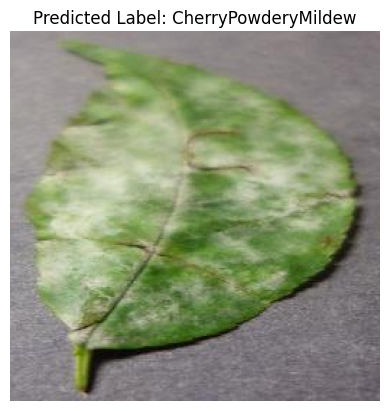

Predicted label: SoybeanHealthy


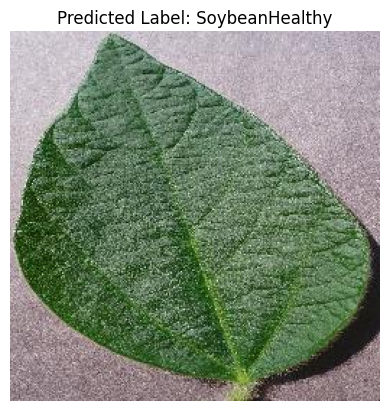

Predicted label: TomatoSeptoriaLeaf


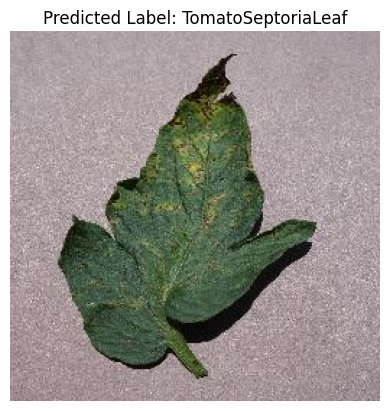

In [4]:
import matplotlib.pyplot as plt

# Define a function to display the image
def show_image(image_path, predicted_label):

    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image)
    plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()


image_paths = [
    '/content/image_cherry_powder.JPG',
    '/content/image_soyabean_healthy.JPG',
    '/content/image_tomato_septoria_leaf.JPG',

]


for image_path in image_paths:
    predicted_label = model.predict_image(image_path)
    print(f"Predicted label: {predicted_label}")
    show_image(image_path, predicted_label)
